# DCNN recreation (Paper baseline) with improvements
This notebook recreates the paper's CNN (VALID 3×3 conv + max-pooling) and applies **two overfitting-reduction improvements**:
- **BatchNorm** (optional toggle – off by default to stay close to paper)
- **Global Average Pooling (GAP)** replacing Flatten

It also uses a **70/15/15 stratified split** (train/val/test) so the test set is withheld.


In [1]:
import os, json, random
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [2]:
# ===== CONFIG (EDIT AS NEEDED) =====
# Keeping your original dataset path style from the notebook you uploaded:
DATA_ROOT = Path("data/EndoscopicBladderTissue_masked_flat")  # <-- your dataset root (must contain class folders)

# Split ratios
TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15
RANDOM_SEED = 42

# Image / training hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 128
EPOCHS = 100
LR = 1e-4
WEIGHT_DECAY = 5e-4
NUM_WORKERS = 2  # set 0 if debugging on Windows

# Output directory
SAVE_DIR = Path("checkpoints_gap_70_15_15")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_BEST_PATH = SAVE_DIR / "cnn17_gap_best.pth"
CLASS_INDEX_PATH = SAVE_DIR / "class_to_idx.json"

# Canonical classes (case-insensitive). Folder names should match these (case-insensitive).
CLASSES = ["HGC", "LGC", "NST", "NTL"]

# Image extensions to include
IMAGE_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".PNG", ".JPG", ".JPEG", ".BMP", ".TIF", ".TIFF"}

assert abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 1e-9, "Split ratios must sum to 1.0"
assert DATA_ROOT.exists(), f"DATA_ROOT does not exist: {DATA_ROOT}"
print("Config OK. DATA_ROOT:", DATA_ROOT.resolve())


Config OK. DATA_ROOT: /home/philipdt/IKT-project/data/EndoscopicBladderTissue_masked_flat


In [3]:
def seed_everything(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

seed_everything(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [4]:
# ---- Scan dataset (expects class folders under DATA_ROOT) ----
# Example structure:
# DATA_ROOT/
#   HGC/
#   LGC/
#   NST/
#   NTL/
def normalize_class_name(name: str) -> str:
    return name.strip().upper()

all_items = []
for class_dir in sorted(DATA_ROOT.iterdir()):
    if not class_dir.is_dir():
        continue
    cls = normalize_class_name(class_dir.name)
    if cls not in [c.upper() for c in CLASSES]:
        continue
    for p in class_dir.rglob("*"):
        if p.suffix in IMAGE_EXTS:
            all_items.append((p, cls))

assert len(all_items) > 0, f"No images found under {DATA_ROOT} for classes {CLASSES}"
print("Total images found:", len(all_items))

classes_present = sorted({cls for _, cls in all_items})
class_to_idx = {c: i for i, c in enumerate(classes_present)}
idx_to_class = {i: c for c, i in class_to_idx.items()}
print("Classes present:", classes_present)

with open(CLASS_INDEX_PATH, "w") as f:
    json.dump(class_to_idx, f, indent=2)
print("Saved class_to_idx to:", CLASS_INDEX_PATH)


Total images found: 1758
Classes present: ['HGC', 'LGC', 'NST', 'NTL']
Saved class_to_idx to: checkpoints_gap_70_15_15/class_to_idx.json


In [5]:
# ---- Stratified 70/15/15 split ----
X_paths = [str(p) for p, _c in all_items]
y_labels = [class_to_idx[_c] for _, _c in all_items]

# First split off test (15%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_paths, y_labels,
    test_size=TEST_RATIO,
    random_state=RANDOM_SEED,
    stratify=y_labels
)

# Then split train/val from the remaining (train=70%, val=15% overall)
# val fraction of the remaining trainval set:
val_fraction_of_trainval = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=val_fraction_of_trainval,
    random_state=RANDOM_SEED,
    stratify=y_trainval
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")


Train: 1230 | Val: 264 | Test: 264


In [6]:
# ---- Transforms ----
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.10, contrast=0.10, saturation=0.05, hue=0.02),
    transforms.ToTensor(),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])


In [7]:
class PathDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        y = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        return img, y

train_ds = PathDataset(X_train, y_train, train_transform)
val_ds   = PathDataset(X_val,   y_val,   eval_transform)
test_ds  = PathDataset(X_test,  y_test,  eval_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Loaders ready.")


Loaders ready.


In [8]:
# ---- Model (paper backbone + GAP + BatchNorm) ----
def conv3x3_valid_bn(cin, cout):
    return nn.Sequential(
        nn.Conv2d(cin, cout, kernel_size=3, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(cout),
        nn.ReLU(inplace=True),
    )

class PaperDCNN17_GAP_BN(nn.Module):
    def __init__(self, num_classes: int, dropout_p: float = 0.5):
        super().__init__()
        self.features = nn.Sequential(
            conv3x3_valid_bn(3,   32),                   # 224 -> 222
            nn.MaxPool2d(kernel_size=2, stride=2),       # 222 -> 111
            conv3x3_valid_bn(32,  64),                   # 111 -> 109
            nn.MaxPool2d(kernel_size=2, stride=2),       # 109 -> 54
            conv3x3_valid_bn(64,  128),                  # 54 -> 52
            nn.MaxPool2d(kernel_size=2, stride=2),       # 52 -> 26
            conv3x3_valid_bn(128, 256),                  # 26 -> 24
            nn.MaxPool2d(kernel_size=2, stride=2),       # 24 -> 12
            conv3x3_valid_bn(256, 512),                  # 12 -> 10
        )
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),                 # [B,512,1,1] -> [B,512]
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_p),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_p),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

num_classes = len(classes_present)
model = PaperDCNN17_GAP_BN(num_classes=num_classes).to(device)

# quick shape check (GPU-safe)
with torch.no_grad():
    y = model(torch.zeros(1, 3, IMG_SIZE, IMG_SIZE).to(device))
print("Model output shape:", y.shape)


Model output shape: torch.Size([1, 4])


In [9]:
# ---- Training utilities (WITH history saving) ----
import json
from pathlib import Path

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

def run_epoch(model, loader, train: bool):
    model.train(train)
    total_loss, correct, total = 0.0, 0, 0

    for x, y in tqdm(loader, leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        logits = model(x)
        loss = criterion(logits, y)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total

# ---- History containers ----
history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

best_val_acc = -1.0

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_epoch(model, train_loader, train=True)
    val_loss, val_acc     = run_epoch(model, val_loader,   train=False)

    # store
    history["epoch"].append(epoch)
    history["train_loss"].append(float(train_loss))
    history["train_acc"].append(float(train_acc))
    history["val_loss"].append(float(val_loss))
    history["val_acc"].append(float(val_acc))

    print(f"Epoch {epoch:03d} | "
          f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_BEST_PATH)
        print(f"  ✓ Saved best model to {MODEL_BEST_PATH} (val acc {best_val_acc:.4f})")

# ---- Save history to disk (CSV + JSON) ----
history_csv_path = SAVE_DIR / "history.csv"
history_json_path = SAVE_DIR / "history.json"

with open(history_csv_path, "w") as f:
    f.write("epoch,train_loss,train_acc,val_loss,val_acc\n")
    for i in range(len(history["epoch"])):
        f.write(f"{history['epoch'][i]},{history['train_loss'][i]},{history['train_acc'][i]},"
                f"{history['val_loss'][i]},{history['val_acc'][i]}\n")

with open(history_json_path, "w") as f:
    json.dump(history, f, indent=2)

print("Saved:", history_csv_path)
print("Saved:", history_json_path)


Epoch 001 | train loss 1.3770 acc 0.2927 | val loss 1.3814 acc 0.2689
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.2689)


Epoch 002 | train loss 1.3180 acc 0.4024 | val loss 1.3379 acc 0.3674
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.3674)


Epoch 003 | train loss 1.2133 acc 0.4602 | val loss 1.2866 acc 0.3598


Epoch 004 | train loss 1.1024 acc 0.5390 | val loss 1.2638 acc 0.3864
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.3864)


Epoch 005 | train loss 1.0074 acc 0.5610 | val loss 1.1860 acc 0.4924
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.4924)


Epoch 006 | train loss 0.9317 acc 0.5862 | val loss 0.9578 acc 0.5720
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.5720)


Epoch 007 | train loss 0.8634 acc 0.6106 | val loss 0.8291 acc 0.6402
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.6402)


Epoch 008 | train loss 0.8079 acc 0.6358 | val loss 0.8047 acc 0.6288


Epoch 009 | train loss 0.7824 acc 0.6398 | val loss 0.8600 acc 0.6742
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.6742)


Epoch 010 | train loss 0.7394 acc 0.6911 | val loss 0.7199 acc 0.7273
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.7273)


Epoch 011 | train loss 0.6909 acc 0.7203 | val loss 0.6590 acc 0.7992
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.7992)


Epoch 012 | train loss 0.6547 acc 0.7577 | val loss 0.6437 acc 0.7538


Epoch 013 | train loss 0.6206 acc 0.7667 | val loss 0.5624 acc 0.7992


Epoch 014 | train loss 0.5667 acc 0.8008 | val loss 0.5143 acc 0.8144
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.8144)


Epoch 015 | train loss 0.5399 acc 0.7959 | val loss 0.5060 acc 0.8258
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.8258)


Epoch 016 | train loss 0.5087 acc 0.8163 | val loss 0.4726 acc 0.8220


Epoch 017 | train loss 0.4879 acc 0.8130 | val loss 0.4791 acc 0.8144


Epoch 018 | train loss 0.4446 acc 0.8398 | val loss 0.4784 acc 0.8409
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.8409)


Epoch 019 | train loss 0.4276 acc 0.8439 | val loss 0.4962 acc 0.8106


Epoch 020 | train loss 0.4212 acc 0.8415 | val loss 0.4523 acc 0.8258


Epoch 021 | train loss 0.4048 acc 0.8382 | val loss 0.4803 acc 0.8106


Epoch 022 | train loss 0.3960 acc 0.8455 | val loss 0.4040 acc 0.8598
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.8598)


Epoch 023 | train loss 0.4077 acc 0.8455 | val loss 0.4212 acc 0.8447


Epoch 024 | train loss 0.3727 acc 0.8650 | val loss 0.4141 acc 0.8485


Epoch 025 | train loss 0.3672 acc 0.8707 | val loss 0.4329 acc 0.8598


Epoch 026 | train loss 0.3689 acc 0.8707 | val loss 0.4465 acc 0.8333


Epoch 027 | train loss 0.3468 acc 0.8740 | val loss 0.3665 acc 0.8712
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.8712)


Epoch 028 | train loss 0.3361 acc 0.8821 | val loss 0.4750 acc 0.8220


Epoch 029 | train loss 0.2951 acc 0.9033 | val loss 0.3378 acc 0.8864
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.8864)


Epoch 030 | train loss 0.3474 acc 0.8902 | val loss 0.5071 acc 0.8106


Epoch 031 | train loss 0.3363 acc 0.8967 | val loss 0.5811 acc 0.7992


Epoch 032 | train loss 0.3423 acc 0.8813 | val loss 0.3117 acc 0.8939
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.8939)


Epoch 033 | train loss 0.3007 acc 0.8992 | val loss 0.3364 acc 0.8826


Epoch 034 | train loss 0.2698 acc 0.9179 | val loss 0.3850 acc 0.8598


Epoch 035 | train loss 0.2599 acc 0.9081 | val loss 0.4377 acc 0.8523


Epoch 036 | train loss 0.2692 acc 0.9041 | val loss 0.3078 acc 0.8902


Epoch 037 | train loss 0.2580 acc 0.9171 | val loss 0.2578 acc 0.9242
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.9242)


Epoch 038 | train loss 0.2609 acc 0.9122 | val loss 0.6489 acc 0.7803


Epoch 039 | train loss 0.2245 acc 0.9154 | val loss 0.2976 acc 0.8939


Epoch 040 | train loss 0.1949 acc 0.9333 | val loss 0.2410 acc 0.9356
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.9356)


Epoch 041 | train loss 0.2052 acc 0.9325 | val loss 0.3073 acc 0.8826


Epoch 042 | train loss 0.1999 acc 0.9350 | val loss 0.3133 acc 0.8977


Epoch 043 | train loss 0.2032 acc 0.9398 | val loss 0.4608 acc 0.8258


Epoch 044 | train loss 0.1948 acc 0.9309 | val loss 0.3357 acc 0.8826


Epoch 045 | train loss 0.2039 acc 0.9309 | val loss 0.2563 acc 0.9091


Epoch 046 | train loss 0.1949 acc 0.9431 | val loss 0.3895 acc 0.8826


Epoch 047 | train loss 0.1789 acc 0.9358 | val loss 0.2659 acc 0.9091


Epoch 048 | train loss 0.1827 acc 0.9382 | val loss 0.3460 acc 0.9015


Epoch 049 | train loss 0.1807 acc 0.9447 | val loss 0.2310 acc 0.9205


Epoch 050 | train loss 0.2127 acc 0.9211 | val loss 0.2609 acc 0.9318


Epoch 051 | train loss 0.1725 acc 0.9407 | val loss 0.2484 acc 0.9167


Epoch 052 | train loss 0.1510 acc 0.9488 | val loss 0.2479 acc 0.9280


Epoch 053 | train loss 0.1708 acc 0.9423 | val loss 0.2348 acc 0.9242


Epoch 054 | train loss 0.1931 acc 0.9415 | val loss 0.2159 acc 0.9394
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.9394)


Epoch 055 | train loss 0.1485 acc 0.9585 | val loss 0.1786 acc 0.9394


Epoch 056 | train loss 0.1377 acc 0.9496 | val loss 0.2791 acc 0.9091


Epoch 057 | train loss 0.1290 acc 0.9577 | val loss 0.1832 acc 0.9280


Epoch 058 | train loss 0.1221 acc 0.9642 | val loss 0.2070 acc 0.9318


Epoch 059 | train loss 0.1393 acc 0.9561 | val loss 0.1904 acc 0.9432
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.9432)


Epoch 060 | train loss 0.1325 acc 0.9569 | val loss 0.2151 acc 0.9356


Epoch 061 | train loss 0.1459 acc 0.9463 | val loss 0.1692 acc 0.9356


Epoch 062 | train loss 0.1095 acc 0.9667 | val loss 0.1626 acc 0.9470
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.9470)


Epoch 063 | train loss 0.1162 acc 0.9634 | val loss 0.2173 acc 0.9242


Epoch 064 | train loss 0.1216 acc 0.9602 | val loss 0.1990 acc 0.9394


Epoch 065 | train loss 0.1177 acc 0.9642 | val loss 0.2076 acc 0.9053


Epoch 066 | train loss 0.1153 acc 0.9642 | val loss 0.3208 acc 0.9015


Epoch 067 | train loss 0.1062 acc 0.9707 | val loss 0.1496 acc 0.9508
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.9508)


Epoch 068 | train loss 0.1114 acc 0.9691 | val loss 0.2862 acc 0.8939


Epoch 069 | train loss 0.1016 acc 0.9634 | val loss 0.1798 acc 0.9545
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.9545)


Epoch 070 | train loss 0.1216 acc 0.9585 | val loss 0.1899 acc 0.9356


Epoch 071 | train loss 0.1043 acc 0.9618 | val loss 0.1136 acc 0.9621
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.9621)


Epoch 072 | train loss 0.0998 acc 0.9642 | val loss 0.2321 acc 0.9280


Epoch 073 | train loss 0.1163 acc 0.9569 | val loss 0.1486 acc 0.9583


Epoch 074 | train loss 0.0991 acc 0.9699 | val loss 0.1763 acc 0.9432


Epoch 075 | train loss 0.1223 acc 0.9577 | val loss 0.1235 acc 0.9583


Epoch 076 | train loss 0.1005 acc 0.9667 | val loss 0.2958 acc 0.9129


Epoch 077 | train loss 0.1027 acc 0.9691 | val loss 0.4937 acc 0.8864


Epoch 078 | train loss 0.0895 acc 0.9707 | val loss 0.3174 acc 0.8826


Epoch 079 | train loss 0.1185 acc 0.9626 | val loss 0.2139 acc 0.9394


Epoch 080 | train loss 0.1072 acc 0.9650 | val loss 0.1824 acc 0.9545


Epoch 081 | train loss 0.0837 acc 0.9740 | val loss 0.1525 acc 0.9432


Epoch 082 | train loss 0.0956 acc 0.9707 | val loss 0.1750 acc 0.9432


Epoch 083 | train loss 0.0843 acc 0.9732 | val loss 0.1999 acc 0.9356


Epoch 084 | train loss 0.0923 acc 0.9683 | val loss 0.2692 acc 0.9167


Epoch 085 | train loss 0.1137 acc 0.9642 | val loss 0.1530 acc 0.9659
  ✓ Saved best model to checkpoints_gap_70_15_15/cnn17_gap_best.pth (val acc 0.9659)


Epoch 086 | train loss 0.0908 acc 0.9707 | val loss 0.2144 acc 0.9394


Epoch 087 | train loss 0.0910 acc 0.9667 | val loss 0.2503 acc 0.9242


Epoch 088 | train loss 0.0959 acc 0.9659 | val loss 0.3269 acc 0.9167


Epoch 089 | train loss 0.0751 acc 0.9780 | val loss 0.1344 acc 0.9470


Epoch 090 | train loss 0.1089 acc 0.9626 | val loss 0.1929 acc 0.9470


Epoch 091 | train loss 0.1089 acc 0.9683 | val loss 0.2774 acc 0.9280


Epoch 092 | train loss 0.1008 acc 0.9691 | val loss 0.1717 acc 0.9545


Epoch 093 | train loss 0.0759 acc 0.9748 | val loss 0.1480 acc 0.9583


Epoch 094 | train loss 0.0789 acc 0.9748 | val loss 0.2271 acc 0.9280


Epoch 095 | train loss 0.0824 acc 0.9740 | val loss 0.1932 acc 0.9356


Epoch 096 | train loss 0.0778 acc 0.9715 | val loss 0.1580 acc 0.9508


Epoch 097 | train loss 0.0729 acc 0.9740 | val loss 0.0957 acc 0.9659


Epoch 098 | train loss 0.0673 acc 0.9756 | val loss 0.1127 acc 0.9621


Epoch 099 | train loss 0.0742 acc 0.9740 | val loss 0.1290 acc 0.9621


Epoch 100 | train loss 0.0788 acc 0.9756 | val loss 0.2089 acc 0.9280
Saved: checkpoints_gap_70_15_15/history.csv
Saved: checkpoints_gap_70_15_15/history.json


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Test accuracy: 0.9356
Test macro F1: 0.9151
Test weighted F1: 0.9364

Classification report:
              precision    recall  f1-score   support

         HGC       0.99      0.93      0.96        71
         LGC       0.92      1.00      0.96        97
         NST       1.00      0.86      0.92        76
         NTL       0.73      0.95      0.83        20

    accuracy                           0.94       264
   macro avg       0.91      0.93      0.92       264
weighted avg       0.94      0.94      0.94       264


Confusion matrix (counts):
[[66  4  0  1]
 [ 0 97  0  0]
 [ 1  4 65  6]
 [ 0  1  0 19]]


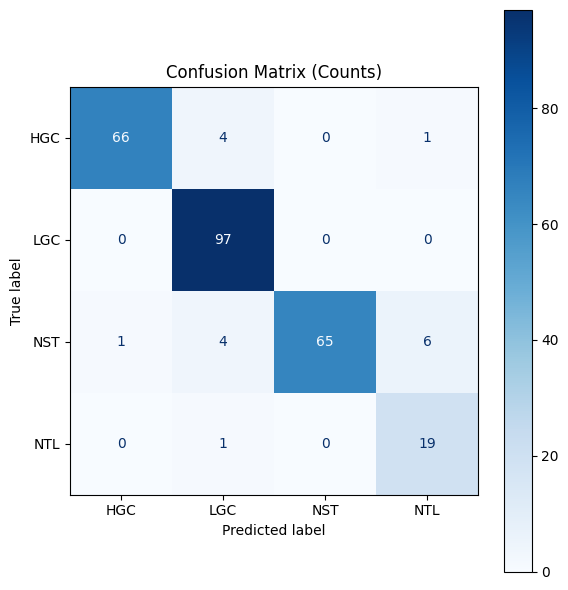

In [12]:
# ---- Evaluate on withheld TEST set using best checkpoint ----
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

best_model = PaperDCNN17_GAP_BN(num_classes=num_classes).to(device)
best_model.load_state_dict(torch.load(MODEL_BEST_PATH, map_location=device))
best_model.eval()

correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = best_model(x)
        preds = logits.argmax(1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(y.cpu().tolist())

        correct += (preds == y).sum().item()
        total += y.size(0)

# ---- Metrics ----
test_acc = correct / total
macro_f1 = f1_score(all_labels, all_preds, average="macro")
weighted_f1 = f1_score(all_labels, all_preds, average="weighted")

print(f"Test accuracy: {test_acc:.4f}")
print(f"Test macro F1: {macro_f1:.4f}")
print(f"Test weighted F1: {weighted_f1:.4f}")

print("\nClassification report:")
print(classification_report(
    all_labels,
    all_preds,
    target_names=[idx_to_class[i] for i in range(num_classes)]
))

# ---- Confusion matrix (RAW counts, not normalized) ----
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion matrix (counts):")
print(cm)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[idx_to_class[i] for i in range(num_classes)]
)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(
    ax=ax,
    cmap="Blues",
    colorbar=True,
    values_format="d"
)
ax.set_title("Confusion Matrix (Counts)")
plt.tight_layout()
plt.savefig(fig_dir / "confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.savefig(fig_dir / "confusion_matrix.pdf", bbox_inches="tight")
plt.show()


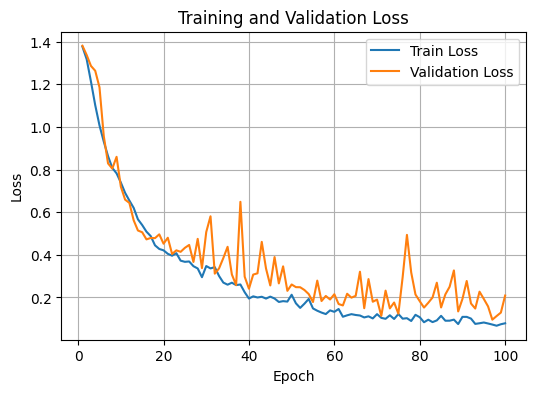

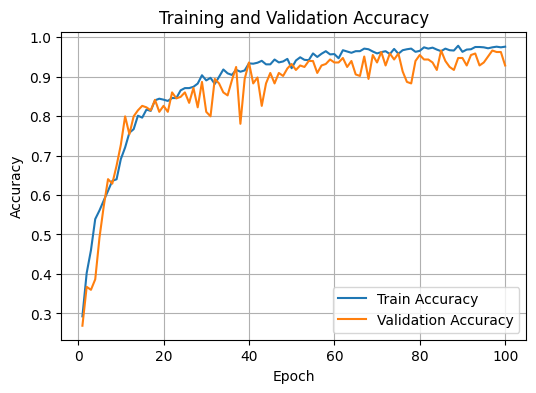

In [11]:
# ---- Plot training history ----
import csv
import matplotlib.pyplot as plt
from pathlib import Path

history_csv_path = SAVE_DIR / "history.csv"
fig_dir = SAVE_DIR / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

epochs = []
train_loss = []
val_loss = []
train_acc = []
val_acc = []

with open(history_csv_path, "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        epochs.append(int(row["epoch"]))
        train_loss.append(float(row["train_loss"]))
        val_loss.append(float(row["val_loss"]))
        train_acc.append(float(row["train_acc"]))
        val_acc.append(float(row["val_acc"]))

# ---- Loss plot ----
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

plt.savefig(fig_dir / "loss_curve.png", dpi=300, bbox_inches="tight")
plt.savefig(fig_dir / "loss_curve.pdf", bbox_inches="tight")  # optional PDF for LaTeX
plt.show()

# ---- Accuracy plot ----
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)

plt.savefig(fig_dir / "accuracy_curve.png", dpi=300, bbox_inches="tight")
plt.savefig(fig_dir / "accuracy_curve.pdf", bbox_inches="tight")
plt.show()
